In [3]:
!pip install rouge_score
!pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b5bc5e3d86f41bf5c6a46b9ce89662a0c17eebe372c1c561d4092a60fbc0b892
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [15]:
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import wandb
import numpy
import evaluate
from tqdm import tqdm
import torch
import itertools
import numpy as np
import matplotlib.pyplot as plt


from collections import Counter
from datasets import load_dataset,Dataset,DatasetDict


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/samsum-train.csv
/kaggle/input/samsum-test.csv
/kaggle/input/samsum-validation.csv
/kaggle/input/samsum_dataset/dataset_dict.json
/kaggle/input/samsum_dataset/validation/state.json
/kaggle/input/samsum_dataset/validation/dataset_info.json
/kaggle/input/samsum_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/samsum_dataset/test/state.json
/kaggle/input/samsum_dataset/test/dataset_info.json
/kaggle/input/samsum_dataset/test/data-00000-of-00001.arrow
/kaggle/input/samsum_dataset/train/state.json
/kaggle/input/samsum_dataset/train/dataset_info.json
/kaggle/input/samsum_dataset/train/data-00000-of-00001.arrow


In [16]:
wandb.init(mode="disabled")


In [17]:
!pip install -U nltk

import nltk

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [18]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 24.7 MB/s eta 0:00:00


# Loading The SamSum Dataset


In [20]:
dataset_samsum = load_dataset("samsum")
dataset_samsum
dataset_samsum["train"][:10]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  Y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

{'id': ['13818513',
  '13728867',
  '13681000',
  '13730747',
  '13728094',
  '13716343',
  '13611672',
  '13730463',
  '13809976',
  '13809912'],
 'dialogue': ["Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
  'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great',
  "Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",
  "Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: 

In [19]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
split_lengths

NameError: name 'dataset_samsum' is not defined

In [9]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [21]:
def analyze_lengths(dataset, dataset_label):
    """
    Analyze text data lengths.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    print(f"Analyze lengths for '{dataset_label}':")
    print(f"- Dialogues: Mean={sum(dialogue_lengths) / len(dialogue_lengths):.2f}, Max={max(dialogue_lengths)}, Min={min(dialogue_lengths)}")
    print(f"- Summaries: Mean={sum(summary_lengths) / len(summary_lengths):.2f}, Max={max(summary_lengths)}, Min={min(summary_lengths)}\n")
    return

# Analyze lengths
analyze_lengths(dataset_samsum, "train")
analyze_lengths(dataset_samsum, "validation")
analyze_lengths(dataset_samsum, "test")

Analyze lengths for 'train':
- Dialogues: Mean=93.79, Max=803, Min=0
- Summaries: Mean=20.32, Max=64, Min=1

Analyze lengths for 'validation':
- Dialogues: Mean=91.64, Max=540, Min=10
- Summaries: Mean=20.28, Max=59, Min=3

Analyze lengths for 'test':
- Dialogues: Mean=95.51, Max=516, Min=9
- Summaries: Mean=20.02, Max=58, Min=3



In [22]:
def find_texts_below_length(dataset, dataset_label, max_length=1):
    """
    Find texts with lengths below or equal to a specified value.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    summaries = data["summary"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Identify texts
    short_dialogues = [(ids[i], dialogues[i], summaries[i]) for i, length in enumerate(dialogue_lengths) if length <= max_length]
    short_summaries = [(ids[i], summaries[i], dialogues[i]) for i, length in enumerate(summary_lengths) if length <= max_length]
    # Display results
    print(f"Analyze texts with length <= {max_length} for '{dataset_label}':")
    print("=== Dialogues ===")
    for i, (id, dialogue, summary) in enumerate(short_dialogues):
        print(f"{i+1}. (id {id}) Dialogue ({len(dialogue.split())} words):\n{dialogue}")
        print(f"   Associated Summary ({len(summary.split())} words): {summary}\n")
    print("\n=== Summaries ===")
    for i, (id, summary, dialogue) in enumerate(short_summaries):
        print(f"{i+1}. (id {id}) Summary ({len(summary.split())} words): {summary}")
        print(f"   Associated Dialogue ({len(dialogue.split())} words):\n{dialogue}\n")
    print()
    return


# Analyze extreme texts (min & max)
find_texts_below_length(dataset_samsum, "train", 2)
find_texts_below_length(dataset_samsum, "validation", 2)
find_texts_below_length(dataset_samsum, "test", 2)

Analyze texts with length <= 2 for 'train':
=== Dialogues ===
1. (id 13828807) Dialogue (0 words):

   Associated Summary (6 words): problem with visualization of the content


=== Summaries ===
1. (id 13810635) Summary (1 words): test
   Associated Dialogue (65 words):
Rivka: How do you like your neighborhood
Coen: I dont like them much
Rivka: Why is that so?
Coen: They are so mean like they play songs at loud music even late night
Rivka: Maybe you can request them to slow down the volume
Coen: We have tried to do so
Rivka: Why dont you ask your mother to visit their place?
Coen: I will

2. (id 13727708) Summary (1 words): yyy
   Associated Dialogue (30 words):
Sue: WOW! you look awesome in this picture
Joanna: The dress covered it up
Sue: Are you coming back?
Joanna: Yeah, I'm in a hurry
Joanna: Speak to you later!

3. (id 13864563) Summary (2 words): Manchester won.
   Associated Dialogue (9 words):
Parker: I told you 
Laila: What?
Wisner: Manchester won... 

4. (id 13681708) Summar

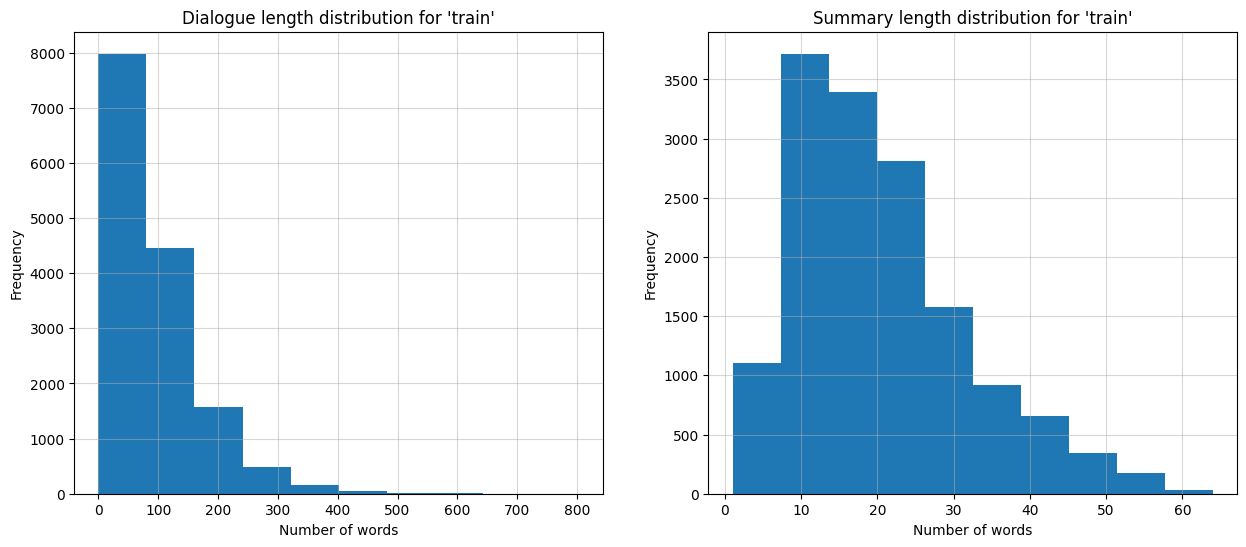

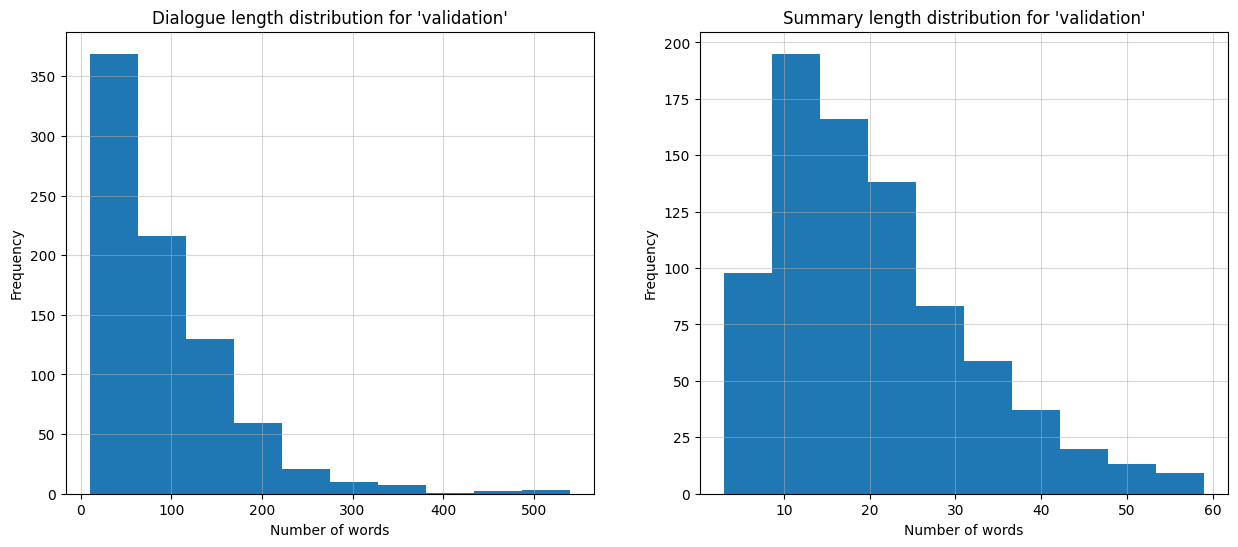

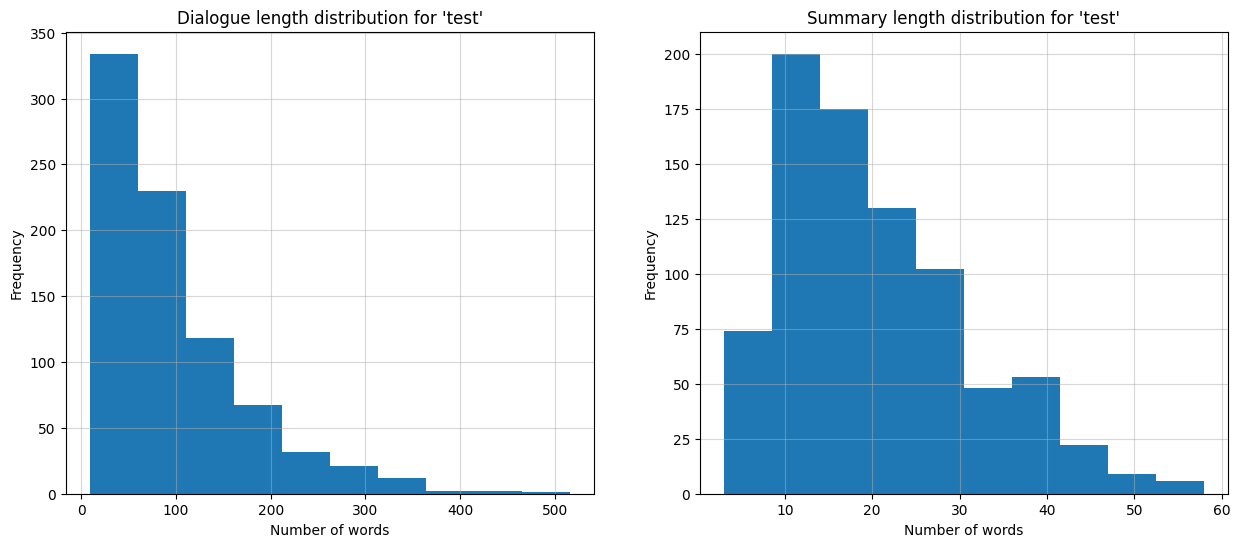

In [23]:
def plot_length_distribution(dataset, dataset_label):
    """
    Plot text lengths distribution.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Plot dialogue length distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dialogue_lengths)
    plt.title(f"Dialogue length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.5)
    # Plot summary length distribution
    plt.subplot(1, 2, 2)
    plt.hist(summary_lengths)
    plt.title(f"Summary length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.5)
    plt.show()
    return

# Graficar para diálogos y resúmenes
plot_length_distribution(dataset_samsum, "train")
plot_length_distribution(dataset_samsum, "validation")
plot_length_distribution(dataset_samsum, "test")

In [24]:
def analyze_word_frequency(dataset, dataset_label, top_n=10):
    """
    Count most common words.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_words = list(itertools.chain(*[sample.split() for sample in dialogues]))
    summary_words = list(itertools.chain(*[sample.split() for sample in summaries]))
    # Get word frequency
    dialogue_word_counts = Counter(dialogue_words)
    summary_word_counts = Counter(summary_words)
    dialogue_most_common = dialogue_word_counts.most_common(top_n)
    summary_most_common = summary_word_counts.most_common(top_n)
    print(f"Analyze word frequency for '{dataset_label}':")
    print("=== Dialogues ===")
    for word, count in dialogue_most_common:
        print(f"{word}: {count}")
    print("\n=== Summaries ===")
    for word, count in summary_most_common:
        print(f"{word}: {count}")
    print()
    return


# Analyze most common words
analyze_word_frequency(dataset_samsum, "train")
analyze_word_frequency(dataset_samsum, "validation")
analyze_word_frequency(dataset_samsum, "test")


Analyze word frequency for 'train':
=== Dialogues ===
I: 37592
you: 31617
the: 29897
to: 28658
a: 21640
and: 15311
it: 14302
for: 11546
in: 10723
of: 10267

=== Summaries ===
to: 11567
and: 10138
the: 9871
a: 7366
is: 6811
will: 6653
for: 4638
in: 4042
at: 3693
her: 3096

Analyze word frequency for 'validation':
=== Dialogues ===
I: 2008
you: 1672
the: 1619
to: 1489
a: 1157
and: 807
it: 763
for: 658
in: 602
is: 560

=== Summaries ===
to: 650
and: 570
the: 562
a: 413
is: 392
will: 334
for: 277
in: 241
at: 227
her: 198

Analyze word frequency for 'test':
=== Dialogues ===
I: 2135
you: 1715
the: 1680
to: 1552
a: 1230
and: 900
it: 756
for: 638
in: 590
is: 577

=== Summaries ===
to: 662
and: 555
the: 513
a: 417
will: 372
is: 364
in: 217
for: 204
at: 202
her: 180



In [25]:
def remove_short_texts(dataset, dataset_label, min_length=2):
    """
    Remove samples where the length of dialogue or summary is < min_length.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Identify samples with dialogue or summary length <= min_length
    valid_indices = [
        i for i, (dialogue_len, summary_len) in enumerate(zip(dialogue_lengths, summary_lengths))
        if dialogue_len >= min_length and summary_len >= min_length
    ]
    filtered_ids = [ids[i] for i in valid_indices]
    filtered_dialogues = [dialogues[i] for i in valid_indices]
    filtered_summaries = [summaries[i] for i in valid_indices]
    # Create new dataset with filtered samples
    filtered_data = {
        "id": filtered_ids,
        "dialogue": filtered_dialogues,
        "summary": filtered_summaries
    }
    filtered_data = Dataset.from_dict(filtered_data)
    print(f"Filtered '{dataset_label}' dataset contains {len(filtered_dialogues)} samples.")
    return filtered_data


# Remove short texts (length <= 1)
filtered_train_dataset = remove_short_texts(dataset_samsum, "train")
filtered_valid_dataset = remove_short_texts(dataset_samsum, "validation")
filtered_test_dataset = remove_short_texts(dataset_samsum, "test")

filtered_dataset = DatasetDict({
    "train": filtered_train_dataset,
    "valid": filtered_valid_dataset,
    "test": filtered_test_dataset
})

Filtered 'train' dataset contains 14729 samples.
Filtered 'validation' dataset contains 818 samples.
Filtered 'test' dataset contains 819 samples.


In [26]:
def preprocess_texts(dataset, dataset_label):
    """
    Preprocess the dialogue and summary texts by:
    - Replacing \r with '' to remove carriage returns.
    - Replacing \n with <speaker> to mark changes in speaker.
    - Removing extra spaces.
    - Stripping leading/trailing spaces.
    - Converting to lowercase.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    processed_dialogues = [
        re.sub(r'\s+', ' ', re.sub(r"\r", "", re.sub(r"\n", " <speaker> ", dialogue))).strip().lower()
        for dialogue in dialogues
    ]
    processed_summaries = [summary.strip().lower() for summary in summaries]
    # Create new dataset with filtered samples
    filtered_data = {
        "id": ids,
        "dialogue": processed_dialogues,
        "summary": processed_summaries
    }
    filtered_data = Dataset.from_dict(filtered_data)
    print(f"Preprocessing completed for '{dataset_label}' dataset.")
    return filtered_data


# Preprocess texts
filtered_train_dataset = preprocess_texts(filtered_dataset, "train")
filtered_valid_dataset = preprocess_texts(filtered_dataset, "valid")
filtered_test_dataset = preprocess_texts(filtered_dataset, "test")

filtered_dataset_samsum = DatasetDict({
    "train": filtered_train_dataset,
    "valid": filtered_valid_dataset,
    "test": filtered_test_dataset
})

Preprocessing completed for 'train' dataset.
Preprocessing completed for 'valid' dataset.
Preprocessing completed for 'test' dataset.


In [27]:
#Summarizartion Baseline
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

# Pegasus
**Loading Pegasus**
We use pegasus model pretrained on the cnn_dailymail dataset, so we will be evaluatuing Pegasus on the CNN/DailyMail dataset, and then we will fine tune it for SamSum dataset

In [17]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [18]:
pipe_out = pipe(filtered_dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
amanda: he called her last time we were at the park together.
 hannah: i don't know him well.
amanda: don't be shy, he's very nice .


# ROUGE
ROUGE stands for Recall-Oriented Understudy for
Gisting Evaluation. It includes measures to automatically determine the quality of a summary by comparing it to other (ideal) summaries created by
humans.

Ref: https://aclanthology.org/W04-1013.pdf

We will use it as a metric for evaluating the summaries Pegasus create and also we will use it to compare it to other SOTA in text summarization

In [28]:
rouge_metric = evaluate.load("rouge")


In [29]:
reference  = filtered_dataset["test"][1]["summary"]

records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]



# Summaries Evaluation
In this section, we create the methods necessary for summary evaluation.

evaluate_summaries_pegasus is function which

In [21]:
def evaluate_summaries_baseline(dataset, metric, column_text, column_summary):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score


In [22]:
test_sampled = filtered_dataset["test"].shuffle(seed=42).select(range(818))

score = evaluate_summaries_baseline(test_sampled, rouge_metric, "dialogue", "summary")
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.297648,0.086217,0.229271,0.266833


# Pegasus fine-tuning for the SamSum dataset

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
d_len = [len(tokenizer.encode(s)) for s in filtered_dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in filtered_dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1153 > 1024). Running this sequence through the model will result in indexing errors


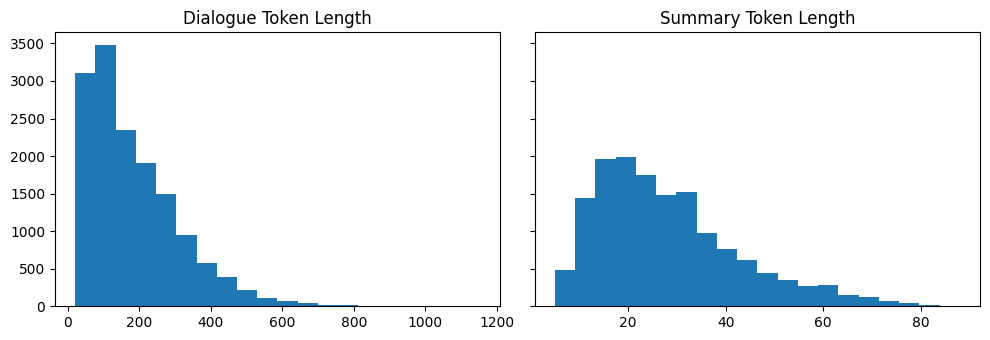

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
plt.tight_layout()
plt.show()

In [27]:
tokenizer.as_target_tokenizer()

In [28]:
#lets tokenize the dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
        
    return {
        "input_ids": input_encodings["input_ids"], 
        "attention_mask": input_encodings["attention_mask"],  
        "labels": target_encodings["input_ids"]
    }

In [29]:
dataset_samsum_pt = filtered_dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/14729 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

**FINE TUNING**

In [30]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [31]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments( output_dir="pegasus-samsum",
                                 num_train_epochs=1,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10, 
                                 push_to_hub=True,
                                 evaluation_strategy='steps', 
                                 eval_steps=500,
                                 save_steps=1e6,
                                 gradient_accumulation_steps=16,
                                 remove_unused_columns=False,
                                 report_to="none" #wandb disabled)
                                 )

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [35]:
trainer = Trainer(
            model=model, 
            args=training_args,
            tokenizer=tokenizer, 
            data_collator=seq2seq_data_collator,
            train_dataset=dataset_samsum_pt["train"],
            eval_dataset=dataset_samsum_pt["valid"])

/tmp/ipykernel_23/3850515099.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
#!pip3 install numpy==1.23.5


In [37]:
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.544900,1.398623


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=920, training_loss=1.7641460024792215, metrics={'train_runtime': 2038.5502, 'train_samples_per_second': 7.225, 'train_steps_per_second': 0.451, 'total_flos': 7625544902443008.0, 'train_loss': 1.7641460024792215, 'epoch': 0.999388960554009})

In [38]:
trainer.push_to_hub("Training complete.")

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


CommitInfo(commit_url='https://huggingface.co/ch4m3l1on/pegasus-samsum/commit/234644eb1d51f2bf89472b603d66fe5fb0cd7ccf', commit_message='Training complete.', commit_description='', oid='234644eb1d51f2bf89472b603d66fe5fb0cd7ccf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ch4m3l1on/pegasus-samsum', endpoint='https://huggingface.co', repo_type='model', repo_id='ch4m3l1on/pegasus-samsum'), pr_revision=None, pr_num=None)

# Testing the fine tuned Pegasus

In [42]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ch4m3l1on/pegasus-samsum")
model = AutoModelForSeq2SeqLM.from_pretrained("ch4m3l1on/pegasus-samsum").to(device)

In [31]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements.""" 
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [37]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device,column_text="article",column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size)) 
        
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
            inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
            print(type(article_batch))
            summaries = model.generate(input_ids=inputs["input_ids"].to(device),attention_mask=inputs["attention_mask"].to(device), length_penalty=0.8, num_beams=8, max_length=128)
            
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,clean_up_tokenization_spaces=True) for s in summaries]
        
            decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries] 
            metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
        
    return score

In [38]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

  0%|          | 0/103 [00:00<?, ?it/s]

<class 'list'>


  1%|          | 1/103 [00:04<07:35,  4.47s/it]

<class 'list'>


  2%|▏         | 2/103 [00:07<06:33,  3.89s/it]

<class 'list'>


  3%|▎         | 3/103 [00:11<06:27,  3.88s/it]

<class 'list'>


  4%|▍         | 4/103 [00:15<06:07,  3.72s/it]

<class 'list'>


  5%|▍         | 5/103 [00:18<05:54,  3.62s/it]

<class 'list'>


  6%|▌         | 6/103 [00:22<05:45,  3.56s/it]

<class 'list'>


  7%|▋         | 7/103 [00:25<05:42,  3.57s/it]

<class 'list'>


  8%|▊         | 8/103 [00:29<05:32,  3.50s/it]

<class 'list'>


  9%|▊         | 9/103 [00:33<05:40,  3.63s/it]

<class 'list'>


 10%|▉         | 10/103 [00:36<05:38,  3.64s/it]

<class 'list'>


 11%|█         | 11/103 [00:40<05:30,  3.59s/it]

<class 'list'>


 12%|█▏        | 12/103 [00:43<05:23,  3.56s/it]

<class 'list'>


 13%|█▎        | 13/103 [00:47<05:17,  3.53s/it]

<class 'list'>


 14%|█▎        | 14/103 [00:51<05:31,  3.72s/it]

<class 'list'>


 15%|█▍        | 15/103 [00:56<06:11,  4.23s/it]

<class 'list'>


 16%|█▌        | 16/103 [01:00<05:49,  4.02s/it]

<class 'list'>


 17%|█▋        | 17/103 [01:03<05:35,  3.90s/it]

<class 'list'>


 17%|█▋        | 18/103 [01:07<05:21,  3.79s/it]

<class 'list'>


 18%|█▊        | 19/103 [01:10<05:08,  3.67s/it]

<class 'list'>


 19%|█▉        | 20/103 [01:14<05:01,  3.63s/it]

<class 'list'>


 20%|██        | 21/103 [01:17<04:53,  3.59s/it]

<class 'list'>


 21%|██▏       | 22/103 [01:21<05:04,  3.76s/it]

<class 'list'>


 22%|██▏       | 23/103 [01:25<05:03,  3.79s/it]

<class 'list'>


 23%|██▎       | 24/103 [01:29<04:50,  3.68s/it]

<class 'list'>


 24%|██▍       | 25/103 [01:32<04:47,  3.69s/it]

<class 'list'>


 25%|██▌       | 26/103 [01:36<04:50,  3.77s/it]

<class 'list'>


 26%|██▌       | 27/103 [01:40<04:39,  3.68s/it]

<class 'list'>


 27%|██▋       | 28/103 [01:43<04:33,  3.65s/it]

<class 'list'>


 28%|██▊       | 29/103 [01:47<04:25,  3.58s/it]

<class 'list'>


 29%|██▉       | 30/103 [01:50<04:20,  3.57s/it]

<class 'list'>


 30%|███       | 31/103 [01:54<04:16,  3.56s/it]

<class 'list'>


 31%|███       | 32/103 [01:58<04:19,  3.65s/it]

<class 'list'>


 32%|███▏      | 33/103 [02:01<04:12,  3.61s/it]

<class 'list'>


 33%|███▎      | 34/103 [02:05<04:02,  3.52s/it]

<class 'list'>


 34%|███▍      | 35/103 [02:08<04:00,  3.54s/it]

<class 'list'>


 35%|███▍      | 36/103 [02:12<04:03,  3.64s/it]

<class 'list'>


 36%|███▌      | 37/103 [02:16<04:06,  3.73s/it]

<class 'list'>


 37%|███▋      | 38/103 [02:20<03:57,  3.66s/it]

<class 'list'>


 38%|███▊      | 39/103 [02:23<03:56,  3.69s/it]

<class 'list'>


 39%|███▉      | 40/103 [02:27<03:48,  3.63s/it]

<class 'list'>


 40%|███▉      | 41/103 [02:31<03:47,  3.66s/it]

<class 'list'>


 41%|████      | 42/103 [02:34<03:42,  3.65s/it]

<class 'list'>


 42%|████▏     | 43/103 [02:38<03:39,  3.66s/it]

<class 'list'>


 43%|████▎     | 44/103 [02:42<03:43,  3.78s/it]

<class 'list'>


 44%|████▎     | 45/103 [02:45<03:35,  3.72s/it]

<class 'list'>


 45%|████▍     | 46/103 [02:49<03:27,  3.63s/it]

<class 'list'>


 46%|████▌     | 47/103 [02:53<03:25,  3.68s/it]

<class 'list'>


 47%|████▋     | 48/103 [02:56<03:17,  3.59s/it]

<class 'list'>


 48%|████▊     | 49/103 [03:00<03:15,  3.63s/it]

<class 'list'>


 49%|████▊     | 50/103 [03:04<03:16,  3.70s/it]

<class 'list'>


 50%|████▉     | 51/103 [03:07<03:14,  3.73s/it]

<class 'list'>


 50%|█████     | 52/103 [03:11<03:12,  3.77s/it]

<class 'list'>


 51%|█████▏    | 53/103 [03:15<03:06,  3.73s/it]

<class 'list'>


 52%|█████▏    | 54/103 [03:19<03:02,  3.73s/it]

<class 'list'>


 53%|█████▎    | 55/103 [03:22<02:56,  3.68s/it]

<class 'list'>


 54%|█████▍    | 56/103 [03:26<02:55,  3.74s/it]

<class 'list'>


 55%|█████▌    | 57/103 [03:30<02:50,  3.70s/it]

<class 'list'>


 56%|█████▋    | 58/103 [03:33<02:45,  3.67s/it]

<class 'list'>


 57%|█████▋    | 59/103 [03:37<02:38,  3.61s/it]

<class 'list'>


 58%|█████▊    | 60/103 [03:40<02:34,  3.59s/it]

<class 'list'>


 59%|█████▉    | 61/103 [03:44<02:32,  3.63s/it]

<class 'list'>


 60%|██████    | 62/103 [03:48<02:26,  3.58s/it]

<class 'list'>


 61%|██████    | 63/103 [03:51<02:24,  3.61s/it]

<class 'list'>


 62%|██████▏   | 64/103 [03:55<02:22,  3.66s/it]

<class 'list'>


 63%|██████▎   | 65/103 [03:58<02:15,  3.58s/it]

<class 'list'>


 64%|██████▍   | 66/103 [04:02<02:14,  3.65s/it]

<class 'list'>


 65%|██████▌   | 67/103 [04:06<02:10,  3.62s/it]

<class 'list'>


 66%|██████▌   | 68/103 [04:10<02:09,  3.71s/it]

<class 'list'>


 67%|██████▋   | 69/103 [04:13<02:01,  3.58s/it]

<class 'list'>


 68%|██████▊   | 70/103 [04:18<02:10,  3.97s/it]

<class 'list'>


 69%|██████▉   | 71/103 [04:21<02:02,  3.82s/it]

<class 'list'>


 70%|██████▉   | 72/103 [04:25<01:55,  3.72s/it]

<class 'list'>


 71%|███████   | 73/103 [04:28<01:49,  3.65s/it]

<class 'list'>


 72%|███████▏  | 74/103 [04:32<01:45,  3.63s/it]

<class 'list'>


 73%|███████▎  | 75/103 [04:36<01:43,  3.70s/it]

<class 'list'>


 74%|███████▍  | 76/103 [04:40<01:43,  3.85s/it]

<class 'list'>


 75%|███████▍  | 77/103 [04:43<01:37,  3.76s/it]

<class 'list'>


 76%|███████▌  | 78/103 [04:47<01:32,  3.72s/it]

<class 'list'>


 77%|███████▋  | 79/103 [04:50<01:26,  3.62s/it]

<class 'list'>


 78%|███████▊  | 80/103 [04:54<01:23,  3.62s/it]

<class 'list'>


 79%|███████▊  | 81/103 [04:58<01:19,  3.61s/it]

<class 'list'>


 80%|███████▉  | 82/103 [05:02<01:19,  3.76s/it]

<class 'list'>


 81%|████████  | 83/103 [05:05<01:14,  3.73s/it]

<class 'list'>


 82%|████████▏ | 84/103 [05:09<01:11,  3.75s/it]

<class 'list'>


 83%|████████▎ | 85/103 [05:13<01:07,  3.76s/it]

<class 'list'>


 83%|████████▎ | 86/103 [05:17<01:04,  3.77s/it]

<class 'list'>


 84%|████████▍ | 87/103 [05:23<01:09,  4.35s/it]

<class 'list'>


 85%|████████▌ | 88/103 [05:26<01:03,  4.24s/it]

<class 'list'>


 86%|████████▋ | 89/103 [05:30<00:56,  4.02s/it]

<class 'list'>


 87%|████████▋ | 90/103 [05:34<00:51,  3.98s/it]

<class 'list'>


 88%|████████▊ | 91/103 [05:38<00:47,  3.96s/it]

<class 'list'>


 89%|████████▉ | 92/103 [05:42<00:44,  4.00s/it]

<class 'list'>


 90%|█████████ | 93/103 [05:46<00:38,  3.89s/it]

<class 'list'>


 91%|█████████▏| 94/103 [05:49<00:34,  3.85s/it]

<class 'list'>


 92%|█████████▏| 95/103 [05:53<00:29,  3.75s/it]

<class 'list'>


 93%|█████████▎| 96/103 [05:56<00:25,  3.62s/it]

<class 'list'>


 94%|█████████▍| 97/103 [06:00<00:21,  3.63s/it]

<class 'list'>


 95%|█████████▌| 98/103 [06:03<00:18,  3.63s/it]

<class 'list'>


 96%|█████████▌| 99/103 [06:08<00:15,  3.92s/it]

<class 'list'>


 97%|█████████▋| 100/103 [06:12<00:11,  3.94s/it]

<class 'list'>


 98%|█████████▊| 101/103 [06:16<00:07,  3.82s/it]

<class 'list'>


 99%|█████████▉| 102/103 [06:19<00:03,  3.70s/it]

<class 'list'>


100%|██████████| 103/103 [06:20<00:00,  3.70s/it]


AttributeError: 'numpy.float64' object has no attribute 'mid'

In [39]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

In [40]:
pd.DataFrame.from_records(rouge_dict, index=[f"pegasus"])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.432084,0.201993,0.344746,0.344546


In [41]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = filtered_dataset["test"][0]["dialogue"]
reference = filtered_dataset["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.
